In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os import makedirs
from os.path import dirname, basename, exists, isdir
import glob as glob

In [2]:
# Read raw dataframe from first level analysis

df = pd.read_csv('data/threat_v_safe_insula_amygdala.txt', header = 0)

df.head()

,Subj,Type,Hem,ROI,VOX,Time,response
0,MAX101,safe,left,left_roi01,left_roi01_001,0.0,-0.038850
1,MAX101,safe,left,left_roi01,left_roi01_002,0.0,-0.150347
2,MAX101,safe,left,left_roi01,left_roi01_003,0.0,-0.165543
3,MAX101,safe,left,left_roi01,left_roi01_004,0.0,-0.258577
4,MAX101,safe,left,left_roi01,left_roi01_005,0.0,-0.457771


In [4]:
def phase(time):
    if (time >= 2.5 and time <= 8.75):
        return 'early'
    elif (time >= 10 and time <= 16.25):
        return 'late'
    else:
        return "pre_early"
    
def Mask(df):
    """
    for left hemisphere, roi01-11 represent insula, roi12-17 represent amygdala
    for right hemishpere, roi01-10 represent insula, roi11-16 represent amygdala
    """
    hem, subROI = df.split("_")
    if (hem == "left") & (int(subROI[3:]) <= 11):
        return "insula"
    elif (hem == "left") & (int(subROI[3:]) > 11):
        return "amygdala"
    elif (hem == "right") & (int(subROI[3:]) <= 10):
        return "insula"
    else:
        return "amygdala"

In [5]:
df['Phase'] = df["Time"].apply(lambda x: phase(x))
df["Mask"] = df["ROI"].apply(lambda x: Mask(x))

df.head()

,Subj,Type,Hem,ROI,VOX,Time,response,Phase,Mask
0,MAX101,safe,left,left_roi01,left_roi01_001,0.0,-0.038850,pre_early,insula
1,MAX101,safe,left,left_roi01,left_roi01_002,0.0,-0.150347,pre_early,insula
2,MAX101,safe,left,left_roi01,left_roi01_003,0.0,-0.165543,pre_early,insula
3,MAX101,safe,left,left_roi01,left_roi01_004,0.0,-0.258577,pre_early,insula
4,MAX101,safe,left,left_roi01,left_roi01_005,0.0,-0.457771,pre_early,insula


In [6]:
# create difference coding as response_threat - response_safe

diff_df = df.merge(df, on=["Subj", "Hem", "ROI", "VOX", "Time", "Phase", "Mask"], suffixes= ["_safe", "_threat"])
diff_df = diff_df[(diff_df["Type_safe"] == "safe") & (diff_df["Type_threat"] == "threat")]
diff_df["diff"] = diff_df["response_threat"] - diff_df["response_safe"]
diff_df = diff_df[["Subj", "Hem", "ROI", "VOX", "Time", "diff", "Phase", "Mask"]]

diff_df.head()

,Subj,Hem,ROI,VOX,Time,diff,Phase,Mask
1,MAX101,left,left_roi01,left_roi01_001,0.0,-0.055685,pre_early,insula
5,MAX101,left,left_roi01,left_roi01_002,0.0,0.436725,pre_early,insula
9,MAX101,left,left_roi01,left_roi01_003,0.0,-0.036031,pre_early,insula
13,MAX101,left,left_roi01,left_roi01_004,0.0,0.240008,pre_early,insula
17,MAX101,left,left_roi01,left_roi01_005,0.0,0.266592,pre_early,insula


In [7]:
# summing up diff within each time phase

agg_df = diff_df.groupby(["Subj", "Hem", "Mask", "ROI", "VOX", "Phase"])["diff"].sum(min_count=1).reset_index()

agg_df.head()

,Subj,Hem,Mask,ROI,VOX,Phase,diff
0,MAX101,left,amygdala,left_roi12,left_roi12_001,early,1.370096
1,MAX101,left,amygdala,left_roi12,left_roi12_001,late,0.452566
2,MAX101,left,amygdala,left_roi12,left_roi12_001,pre_early,0.305491
3,MAX101,left,amygdala,left_roi12,left_roi12_002,early,-0.154476
4,MAX101,left,amygdala,left_roi12,left_roi12_002,late,-0.692820


In [8]:
import re

STAI_path = '/data/bswift-1/Pessoa_Lab/MAX/dataset/behavioral/STAI_sums'
 
with open(STAI_path,'r') as file:
    names = re.split('\t| |\n',file.readline())

STAI=pd.read_csv(STAI_path,sep='\t',names=names[:3],skiprows=1)
STAI['Subj'] = STAI['subject'].apply(lambda ID: 'MAX{:03d}'.format(ID))
STAI.drop('subject',axis=1,inplace=True)
STAI = STAI[STAI.Subj.isin(df.Subj)]
STAI.set_index('Subj',inplace=True)
STAI.head()

,TRAIT,STATE
Subj,,
MAX101,27,22
MAX102,47,44
MAX103,33,32
MAX104,24,21
MAX105,56,28


In [9]:
# Standardize the covariates
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
STAI = pd.DataFrame(ss.fit_transform(STAI),columns=STAI.columns,index=STAI.index)
STAI.reset_index(inplace=True)
STAI.head()

,Subj,TRAIT,STATE
0,MAX101,-1.164152,-1.011495
1,MAX102,1.264414,1.539046
2,MAX103,-0.435582,0.147842
3,MAX104,-1.528437,-1.127429
4,MAX105,2.357268,-0.315893


In [10]:
agg_df = agg_df.merge(STAI, how = "left", on = ["Subj"])
agg_df = agg_df.sort_values(["Subj", "Hem", "ROI", "VOX", "Mask"])
agg_df.head()

,Subj,Hem,Mask,ROI,VOX,Phase,diff,TRAIT,STATE
501,MAX101,left,insula,left_roi01,left_roi01_001,early,-0.488774,-1.164152,-1.011495
502,MAX101,left,insula,left_roi01,left_roi01_001,late,-1.671296,-1.164152,-1.011495
503,MAX101,left,insula,left_roi01,left_roi01_001,pre_early,-0.246184,-1.164152,-1.011495
504,MAX101,left,insula,left_roi01,left_roi01_002,early,0.578108,-1.164152,-1.011495
505,MAX101,left,insula,left_roi01,left_roi01_002,late,-1.575689,-1.164152,-1.011495


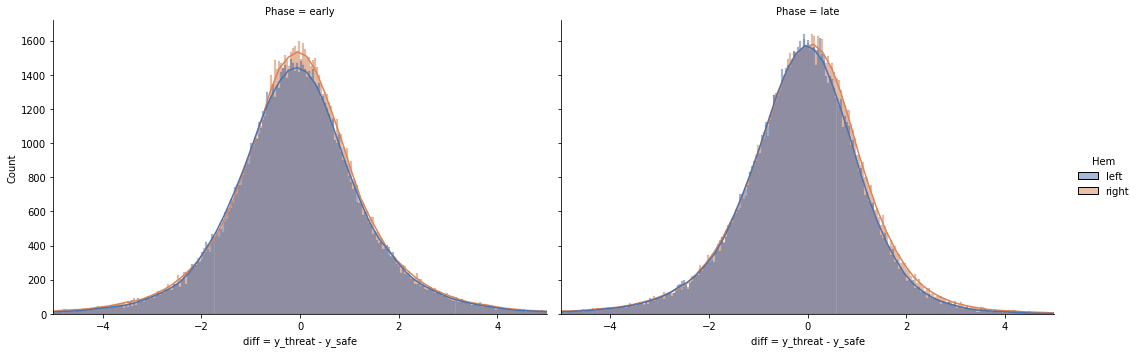

In [14]:
# Density plot for difference of insula at early and late phase with left and right hemisphere respectively 

import seaborn as sns

insula_dens = sns.displot(agg_df[(agg_df['Phase'] != "pre_early") &
                               (agg_df['Mask'] == "insula")], 
                          x = "diff",
                          kde = True, 
                          col = "Phase", hue= "Hem",
                          height = 5, aspect = 1.5, 
                          palette = sns.color_palette('deep', 2))
insula_dens.set(xlim = (-5, 5))
insula_dens.set_xlabels("diff = y_threat - y_safe")

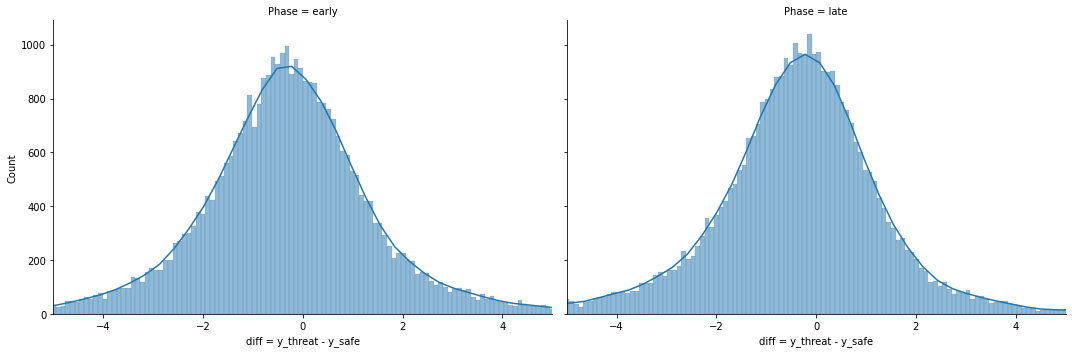

In [15]:
# Density plot for difference of amygdala at early and late phase respectively 

amyg_dens = sns.displot(agg_df[(agg_df['Phase'] != "pre_early") &
                               (agg_df['Mask'] == "amygdala")], 
                        x = "diff",
                        kde = True, 
                        col = "Phase",
                        height = 5, aspect = 1.5, 
                        palette = sns.color_palette('deep', 2))
amyg_dens.set(xlim = (-5, 5))
amyg_dens.set_xlabels("diff = y_threat - y_safe")

In [16]:
# save aggregated dataframe as the input of BML
agg_df.to_csv("data/threat_v_safe_insula_amygdala_agg_diff.txt", index = False)